In [1]:
# ============================================================
# Notebook setup: run this before everything
# ============================================================
# -- Copied from lecture
%load_ext autoreload
%config IPCompleter.greedy=True
%autoreload 1
%aimport util
import logging

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

from util import util

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Control figure size
interactive_figures = False
if interactive_figures:
    # Normal behavior
    %matplotlib widget
    figsize=(9, 3)
else:
    # PDF export behavior
    figsize=(14, 4)

raw_data = util.load_dataset('7_gecco2019_train_water_quality.csv')
raw_data = util.impute_missing_values(raw_data)
feature_columns = util.get_feature_columns(raw_data)

# Split data into features and labels
X = raw_data[feature_columns]
y = raw_data['Event']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Neural Network for Contamination Detection
As the dataset at hand not only contains water composition data, but also a label indicating whether the sample is contaminated or not, we can make use of this extra piece of information to train a neural network for contamination detection. This is a typical, supervised classification problem. The neural network will be trained to predict whether a sample is contaminated or not based on its composition.

## Building the Neural Network
For the neural network, we will use the Keras API as done in the lectures. The architecture is a simple feed-forward neural network with two hidden layers of 32 and 16 neurons each. Additionally, we will include a dropout layer to regularize the model. This helps prevent overfitting and improves generalization. The output layer will have a single neuron with a sigmoid activation function, which is suitable for binary classification problems.

In [2]:
nn1 = util.build_nn_model(input_shape=(len(feature_columns), ), output_shape=1, hidden=[32, 16], with_dropout=True, output_activation='sigmoid')
nn1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 769 (3.00 KB)

 Trainable params: 769 (3.00 KB)

 Non-trainable params: 0 (0.00 B)

## Training the Neural Network
The neural network will be trained using the binary cross-entropy loss function, which is suitable for binary classification problems. The model will be trained for 30 epochs, with a validation split of 20% and a batch size of 16. The training process will be monitored using the loss and F1-score metrics. As the dataset contains only very few contamination events, the F1-score is the ideal metric to evaluate the model's performance.

Epoch 1/30
5300/5300 ━━━━━━━━━━━━━━━━━━━━ 3s 572us/step - f1_score: 0.0612 - loss: 0.0822 - val_f1_score: 0.5000 - val_loss: 0.0037
Epoch 2/30
5300/5300 ━━━━━━━━━━━━━━━━━━━━ 3s 560us/step - f1_score: 0.5657 - loss: 0.0118 - val_f1_score: 0.6154 - val_loss: 0.0028
Epoch 3/30
5300/5300 ━━━━━━━━━━━━━━━━━━━━ 3s 581us/step - f1_score: 0.5755 - loss: 0.0088 - val_f1_score: 0.6154 - val_loss: 0.0025
Epoch 4/30
5300/5300 ━━━━━━━━━━━━━━━━━━━━ 3s 572us/step - f1_score: 0.6598 - loss: 0.0050 - val_f1_score: 0.7660 - val_loss: 0.0030
Epoch 5/30
5300/5300 ━━━━━━━━━━━━━━━━━━━━ 3s 574us/step - f1_score: 0.6820 - loss: 0.0057 - val_f1_score: 0.6500 - val_loss: 0.0022
Epoch 6/30
5300/5300 ━━━━━━━━━━━━━━━━━━━━ 3s 569us/step - f1_score: 0.6025 - loss: 0.0073 - val_f1_score: 0.6667 - val_loss: 0.0021
Epoch 7/30
5300/5300 ━━━━━━━━━━━━━━━━━━━━ 3s 570us/step - f1_score: 0.6048 - loss: 0.0043 - val_f1_score: 0.6500 - val_loss: 0.0022
Epoch 8/30
5300/5300 ━━━━━━━━━━━━━━━━━━━━ 3s 567us/step - f1_score: 0.6534 -

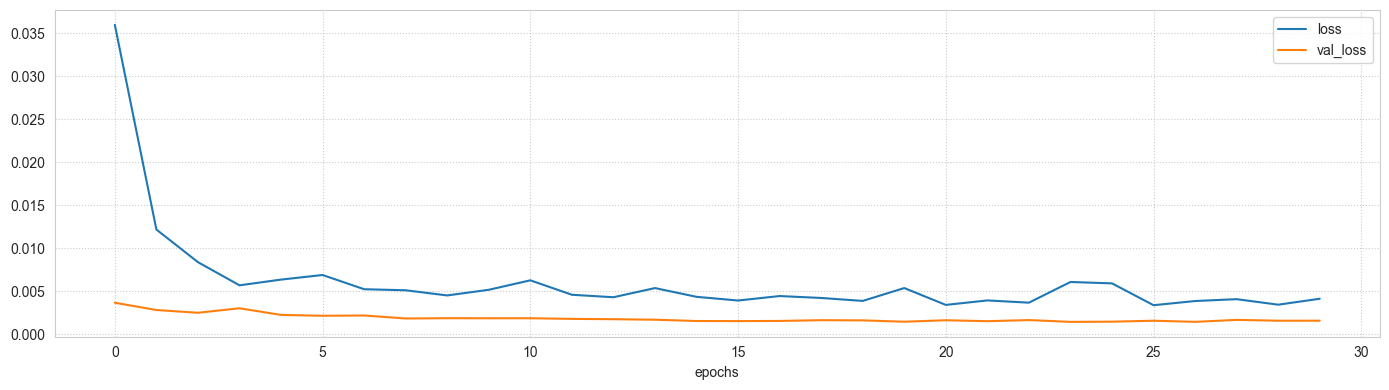

Final scores: loss: 0.0041, val_loss: 0.0016


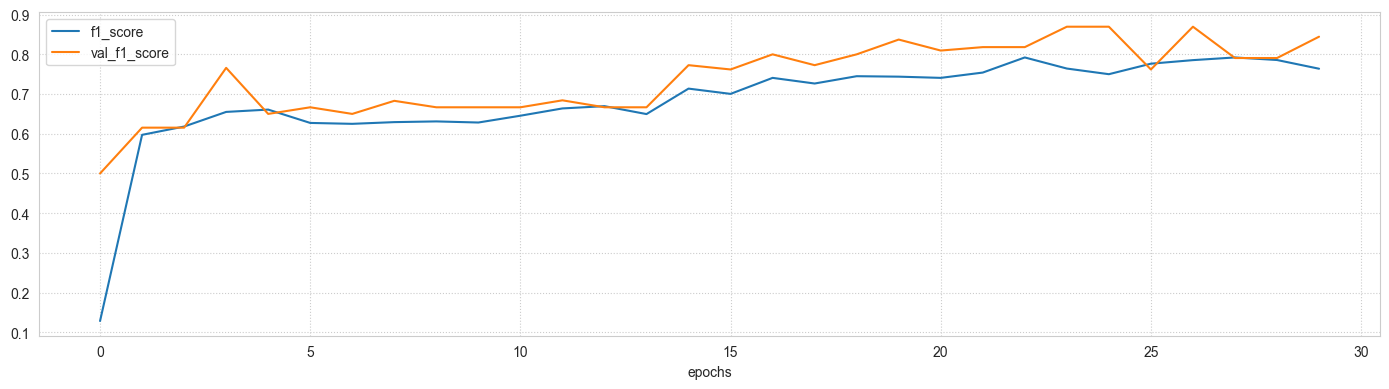

Final scores: f1_score: 0.7638, val_f1_score: 0.8444


In [3]:
# Train the model
f1_score = tf.keras.metrics.F1Score(threshold=0.5)
history = util.train_nn_model(nn1, X_train, y_train, loss='binary_crossentropy', epochs=30, validation_split=0.2, batch_size=16, metrics=[f1_score], verbose=1)

# Pick loss and F1-score from history
loss_history = util.pick_history_keys(history, ['loss', 'val_loss'])
f1_history = util.pick_history_keys(history, ['f1_score', 'val_f1_score'])

# Plot training history
util.plot_training_history(loss_history, figsize=figsize)
util.plot_training_history(f1_history, figsize=figsize)

## Evaluation on the Training Data
After training the neural network, we can evaluate its performance on the training data. The confusion matrix and classification report will be printed to the console.

In [4]:
# Predict probabilities on the test set
y_pred_prob = nn1.predict(X_train)
# Convert probabilities to class labels (thresholding at 0.5 for binary classification)
y_pred = (y_pred_prob > 0.5).astype("int32")


# Print performance metrics
print("Confusion Matrix:\n", confusion_matrix(y_train, y_pred))
print("Classification Report:\n", classification_report(y_train, y_pred))

3312/3312 ━━━━━━━━━━━━━━━━━━━━ 1s 189us/step
Confusion Matrix:
 [[105810      5]
 [    39    130]]
Classification Report:
               precision    recall  f1-score   support

       False       1.00      1.00      1.00    105815
        True       0.96      0.77      0.86       169

    accuracy                           1.00    105984
   macro avg       0.98      0.88      0.93    105984
weighted avg       1.00      1.00      1.00    105984



The feed-forward neural network shows excellent overall performance on the training dataset, with near-perfect accuracy and weighted metrics close to 1.00. The confusion matrix shows that the model correctly classified almost all negative cases, with only 11 false positives and 35 false negatives. However, the performance for the positive class is relatively lower, with a precision of 0.92 and a recall rate of 0.79, suggesting that the network misses some true positive cases. Overall, the network is very effective for the predominant negative class, but further optimization may be needed to better capture the positive cases.

## Evaluation on the Test Data
Much more interesting, however, is the performance on the test data.

In [5]:
# Predict probabilities on the test set
y_pred_prob = nn1.predict(X_test)
# Convert probabilities to class labels (thresholding at 0.5 for binary classification)
y_pred = (y_pred_prob > 0.5).astype("int32")

# Print performance metrics
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

828/828 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step
Confusion Matrix:
 [[26449     4]
 [   14    29]]
Classification Report:
               precision    recall  f1-score   support

       False       1.00      1.00      1.00     26453
        True       0.88      0.67      0.76        43

    accuracy                           1.00     26496
   macro avg       0.94      0.84      0.88     26496
weighted avg       1.00      1.00      1.00     26496



On the test data, the feed-forward neural network maintains very high overall performance. While overall accuracy remains near perfect, the F1-score for the positive class dropped from 0.85 on the training data to 0.78 on the test data, indicating a modest reduction in the model’s balance between precision and recall on unseen data. The confusion matrix for the test set shows minimal misclassifications, with only 5 false positives and 12 false negatives. However, similar to the training results, the performance on the minority (positive) class is significantly lower: the test set shows a precision of 0.86 and a recall of 0.72, compared to 0.92 and 0.79 on the training set. This suggests that while the model generalizes well overall, it still struggles somewhat to consistently detect the positive class in unseen data.